<a href="https://colab.research.google.com/github/Aerospacerr/Fraud-Detection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns
sns.set_style("dark")

from sklearn import preprocessing
from scipy.stats import skew, boxcox

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 170)

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Garanti/train.csv")

In [ ]:
df.isnull().sum()

Id                0
step              0
action            0
amount            0
nameOrig          0
oldBalanceOrig    0
newBalanceOrig    0
nameDest          0
oldBalanceDest    0
newBalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

•	step (int) - maps a unit of time in the real world. In this case 1 step is 1 hour of time

•	type (text) - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

o	CASH-IN: the process of increasing the balance of account by paying in cash to a merchant

o	CASH-OUT: it means to withdraw cash from a merchant which decreases the balance of the account

o	DEBIT: the process of sending the money from the mobile money service to a bank account

o	PAYMENT: process of paying for goods or services to merchants which decreases the balance of the account and increases the balance of the receiver

o	TRANSFER: process of sending money to another user of the service through the mobile money platform

•	amount (double) - amount of the transaction in local currency.

•	nameOrig (text) - customer who started the transaction

•	oldbalanceOrg (double) - initial balance before the transaction

•	newbalanceOrig (double) - new balance after the transaction

•	nameDest (text) - customer who is the recipient of the transaction

•	oldbalanceDest (double) - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

•	newbalanceDest (double) - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

•	isFraud (int) - if the transaction is fraudulent or not (0/1)

•	isFlaggedFraud (int) - an attempt to transfer more than 200.000 in a single transaction (0/1)


In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 2372805
Variables: 12
cat_cols: 3
num_cols: 7
cat_but_car: 2
num_but_cat: 2


In [ ]:
df.head(10)

,Id,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,0,0,TRANSFER,10.000,C0198526315,30112.000,30102.000,C4653045645,21927.840,21937.840,0,0
1,1,1,CASH_IN,104925.190,C9864462944,42.230,104967.410,C7853342674,0.000,0.000,0,0
2,2,1,CASH_IN,37383.170,C1474610910,49.830,37433.010,C3584357969,0.000,0.000,0,0
3,3,1,CASH_IN,131908.490,C1474610910,37433.010,169341.490,C4996589500,0.000,0.000,0,0
4,4,1,CASH_IN,127105.650,C1474610910,169341.490,296447.140,C5989915138,0.000,0.000,0,0
5,5,1,CASH_IN,122532.120,C6906501774,48922.840,171454.970,C6569960846,0.000,0.000,0,0
6,6,1,CASH_IN,175754.740,C3990244078,57.470,175812.200,C3083419878,0.000,0.000,0,0
7,7,1,CASH_IN,138277.060,C9711108201,68.620,138345.680,C9419035356,0.000,0.000,0,0
8,8,1,CASH_IN,56683.890,C3663398590,63.060,56746.950,C9694494939,0.000,0.000,0,0
9,9,1,CASH_IN,165809.670,C9351264623,55.190,165864.860,C7231994265,0.000,0.000,0,0


In [ ]:
df.sample(10)

,Id,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
1093145,1545519,181,CASH_OUT,124213.000,C2053299236,2637227.770,2513014.770,C5686283849,25734.500,25734.500,0,0
1175138,1662041,186,CASH_IN,165836.880,C0043781173,3272061.690,3437898.570,C1094071715,107746.370,107746.370,0,0
460002,650083,38,PAYMENT,7107.450,C9644783493,4733849.770,4726742.320,C2837830264,6937.170,14044.620,0,0
405529,573394,35,CASH_IN,95043.400,C6756023855,3677278.330,3772321.730,C0344332371,10101.930,10101.930,0,0
315943,446827,19,PAYMENT,10724.740,C8282352589,2885222.090,2874497.350,C3590258578,0.000,10724.740,0,0
406768,575202,35,CASH_OUT,217941.100,C6527117052,2159626.070,1941684.970,C1133539180,18791.710,18791.710,0,0
524251,741173,41,PAYMENT,6535.820,C2239735849,4466968.860,4460433.050,C6552590928,22913.110,29448.930,0,0
1517575,2145423,235,CASH_IN,119699.130,C3138612512,2545536.390,2665235.520,C4780435655,164903.350,164903.350,0,0
1296128,1832303,205,CASH_OUT,113194.650,C6875521383,3292447.800,3179253.150,C2040700272,195845.170,195845.170,0,0
1369931,1936258,211,PAYMENT,7816.370,C3459102359,4185647.460,4177831.100,C8159402267,107518.840,115335.210,0,0


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2372805.000,1676995.397,967937.564,0.000,838354.000,1677475.000,2515399.000,3352886.000
step,2372805.000,183.292,125.877,0.000,44.000,187.000,265.000,718.000
amount,2372805.000,145451.915,312216.482,0.110,14368.890,97853.080,171409.560,20268571.110
oldBalanceOrig,2372805.000,3332225.906,1777182.891,-195969.580,2563357.130,3425072.270,4117519.220,49556742.790
newBalanceOrig,2372805.000,3315864.113,1744701.630,-195969.580,2559985.750,3407158.830,4089954.730,48827982.720
oldBalanceDest,2372805.000,282359.093,955456.938,-143907.830,21798.050,77146.570,141409.930,47837977.330
newBalanceDest,2372805.000,329937.822,1138434.869,-62332.570,23911.350,79652.160,144392.820,47993052.840
isFraud,2372805.000,0.000,0.009,0.000,0.000,0.000,0.000,1.000
isFlaggedFraud,2372805.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372805 entries, 0 to 2372804
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Id              int64  
 1   step            int64  
 2   action          object 
 3   amount          float64
 4   nameOrig        object 
 5   oldBalanceOrig  float64
 6   newBalanceOrig  float64
 7   nameDest        object 
 8   oldBalanceDest  float64
 9   newBalanceDest  float64
 10  isFraud         int64  
 11  isFlaggedFraud  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 217.2+ MB


In [ ]:
print('Number of Rows: {}'.format(df.shape[0]))
print('Number of Cols: {}'.format(df.shape[1]))

Number of Rows: 2372805
Number of Cols: 12


CASH_IN     1032064
CASH_OUT     560152
PAYMENT      553096
TRANSFER     139371
DEBIT         88122
Name: action, dtype: int64


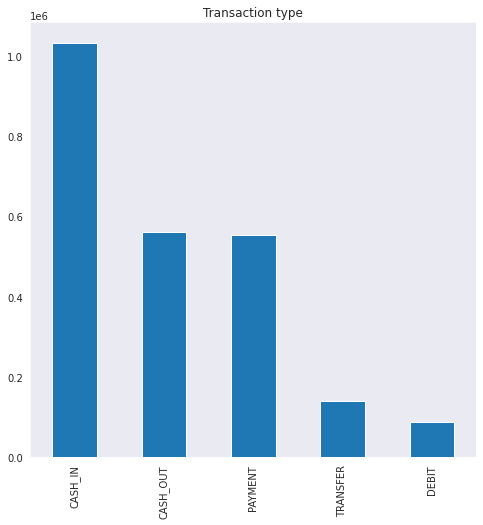

In [ ]:
print(df.action.value_counts())

f, ax = plt.subplots(1, 1, figsize=(8, 8))
df.action.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.show()

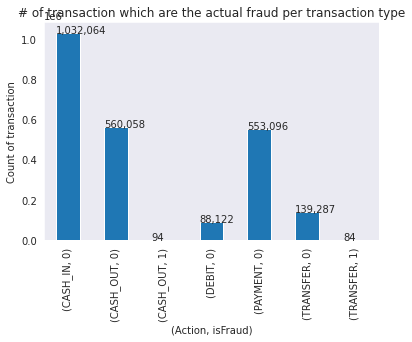

In [ ]:
ax = df.groupby([ 'action','isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Action, isFraud)")
ax.set_ylabel("Count of transaction")

for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

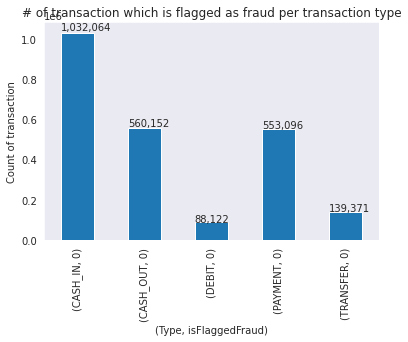

In [ ]:
ax = df.groupby(['action', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which is flagged as fraud per transaction type")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")

for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

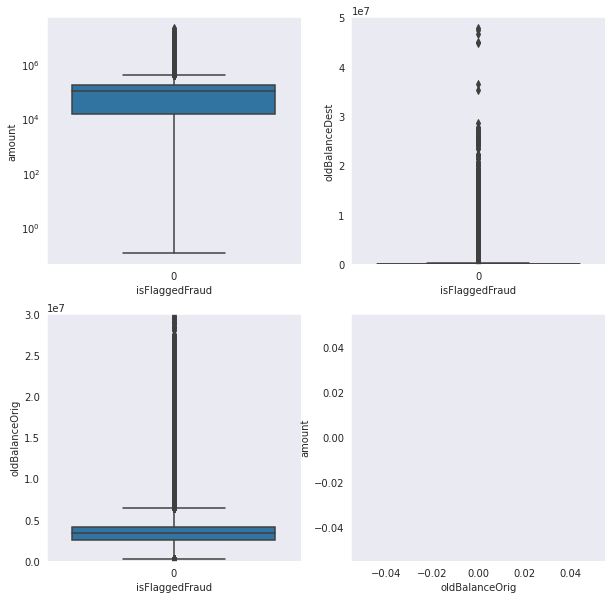

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))


a = sns.boxplot(x = 'isFraud', y = 'amount', data = df, ax=axs[0][0])
axs[0][0].set_yscale('log')
b = sns.boxplot(x = 'isFlaggedFraud', y = 'oldBalanceDest', data = df, ax=axs[0][1])
axs[0][1].set(ylim=(0, 0.5e8))
c = sns.boxplot(x = 'isFlaggedFraud', y = 'oldBalanceOrig', data=df, ax=axs[1][0])
axs[1][0].set(ylim=(0, 3e7))
d = sns.regplot(x = 'oldBalanceOrig', y = 'amount', data=df.loc[(df.isFlaggedFraud ==1), :], ax=axs[1][1])
plt.show()

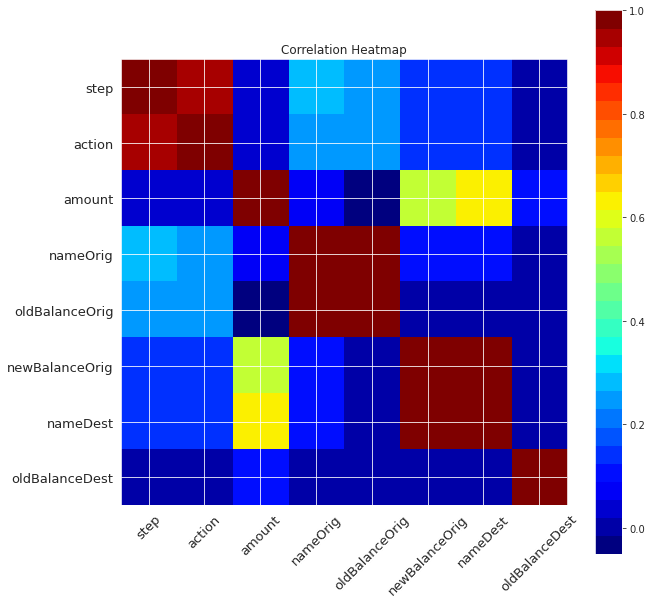

In [ ]:
def correlation_plot(df):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation = "nearest", cmap = cmap)
    ax1.grid(True)
    plt.title("Correlation Heatmap")
    labels = df.columns.tolist()
    ax1.set_xticklabels(labels, fontsize=13, rotation=45)
    ax1.set_yticklabels(labels, fontsize=13)
    fig.colorbar(cax)
    plt.show()


df_temp=df.drop(['isFlaggedFraud'], axis = 1)

correlation_plot(df_temp)

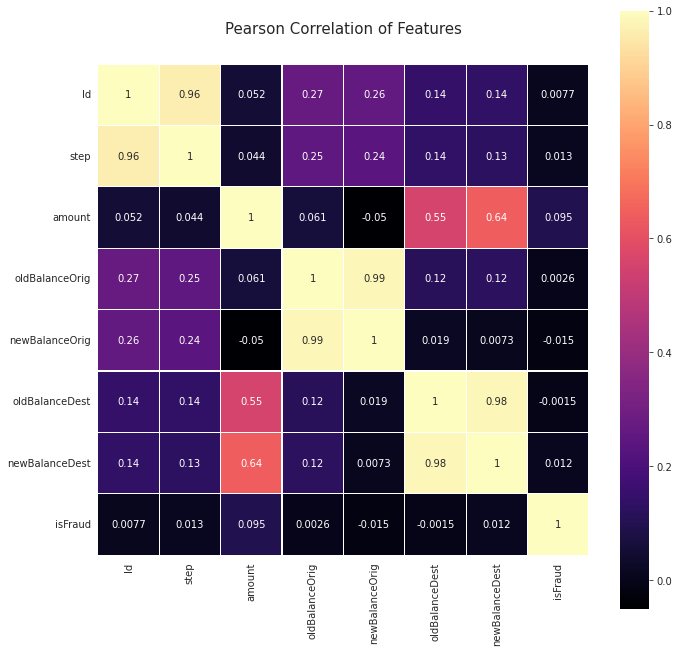

In [ ]:
# Alternatively, we can use quick seaborn
# plot the heatmap
colormap = plt.cm.magma
plt.figure(figsize=(11,11))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_temp.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

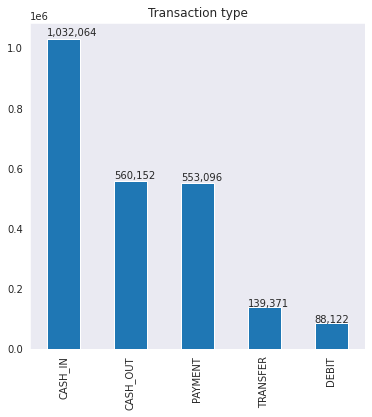

In [ ]:
ax = df.action.value_counts().plot(kind='bar', title="Transaction type", figsize=(6,6))
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

plt.show()

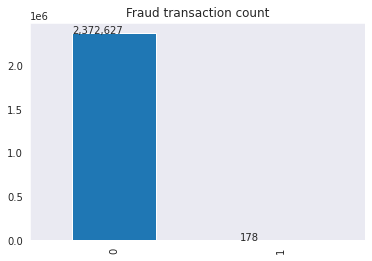

In [ ]:
ax = pd.value_counts(df['isFraud'], sort = True).sort_index().plot(kind='bar', title="Fraud transaction count")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    
plt.show()

In [ ]:
print("The fraud transaction of the filtered dataset: {0:.4f}%".format((len(df[df.isFraud == 1])/len(df)) * 100))

The fraud transaction of the filtered dataset: 0.0075%


# Feature Enginering

In [ ]:
# step
df['step_days'] = df['step'].apply(lambda i: i/24)
df['step_weeks'] = df['step'].apply(lambda i: i/(24*7))

# difference between initial balance before the transaction and new balance after the transaction
df['diff_new_old_balance'] = df['newBalanceOrig'] - df['oldBalanceOrig']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
df['diff_new_old_destiny'] = df['newBalanceDest'] - df['oldBalanceDest']

# categorize for action
df['action'] = df.action.astype('category')
df['acc'] = pd.factorize(df['action'])[0]

In [ ]:
df.head()

,Id,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_destiny,acc
0,0,0,TRANSFER,10.000,C0198526315,30112.000,30102.000,C4653045645,21927.840,21937.840,0,0,0.000,0.000,-10.000,10.000,0
1,1,1,CASH_IN,104925.190,C9864462944,42.230,104967.410,C7853342674,0.000,0.000,0,0,0.042,0.006,104925.180,0.000,1
2,2,1,CASH_IN,37383.170,C1474610910,49.830,37433.010,C3584357969,0.000,0.000,0,0,0.042,0.006,37383.180,0.000,1
3,3,1,CASH_IN,131908.490,C1474610910,37433.010,169341.490,C4996589500,0.000,0.000,0,0,0.042,0.006,131908.480,0.000,1
4,4,1,CASH_IN,127105.650,C1474610910,169341.490,296447.140,C5989915138,0.000,0.000,0,0,0.042,0.006,127105.650,0.000,1


# MACHINE LEARNING

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['action','nameOrig','nameDest','isFraud','isFlaggedFraud'], axis=1).values
y = df['isFraud']

train_X, val_X, train_y, val_y = train_test_split(X, y,test_size = 0.15, random_state = 0)

print("Number transactions train dataset: ", format(len(train_X),',d'))
print("Number transactions validation dataset: ", format(len(val_X), ',d'))
print("Total number of transactions: ", format(len(train_X)+len(val_X), ',d'))

Number transactions train dataset:  2,016,884
Number transactions validation dataset:  355,921
Total number of transactions:  2,372,805


In [ ]:
train_X

array([[ 2.2785380e+06,  2.3900000e+02,  6.2080800e+04, ...,
         6.2080800e+04,  0.0000000e+00,  1.0000000e+00],
       [ 3.1713460e+06,  3.5700000e+02,  2.4833021e+05, ...,
         2.4833021e+05,  0.0000000e+00,  1.0000000e+00],
       [ 3.2929020e+06,  4.9000000e+02,  3.0250853e+05, ...,
         3.0250854e+05,  0.0000000e+00,  1.0000000e+00],
       ...,
       [ 3.1302060e+06,  3.5500000e+02,  7.1151700e+03, ...,
        -7.1151800e+03,  7.1151800e+03,  2.0000000e+00],
       [ 2.0985160e+06,  2.3200000e+02,  1.1000130e+05, ...,
        -1.1000130e+05,  1.1000130e+05,  0.0000000e+00],
       [ 4.3292200e+05,  1.9000000e+01,  9.9925600e+03, ...,
         0.0000000e+00,  0.0000000e+00,  4.0000000e+00]])

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost  import XGBClassifier

from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score

In [ ]:
#######  KNeighborsClassifier #######

neiclassifier = KNeighborsClassifier(n_neighbors=5)  
neiclassifier.fit(train_X, train_y)
y_pred_nei = neiclassifier.predict(val_X)

KNeighbors=[neiclassifier.score(val_X, val_y),precision_score(val_y, y_pred_nei),recall_score(val_y, y_pred_nei),f1_score(val_y,y_pred_nei)]

results=pd.DataFrame(KNeighbors,columns=['DecisionTree'],index=['Accuracy:', 'Precision:', 'Recall:','F1:'])
results['KNeighbors']=KNeighbors

results

,DecisionTree,KNeighbors
Accuracy:,1.000,1.000
Precision:,1.000,1.000
Recall:,0.781,0.781
F1:,0.877,0.877


In [ ]:
#######  DECISION TREE Classifier #######

decision_tree = DecisionTreeClassifier(max_depth = 5,max_features=None)
decision_tree.fit(train_X, train_y)
y_pred_tree = decision_tree.predict(val_X)

DecisionTree=[decision_tree.score(val_X, val_y),precision_score(val_y, y_pred_tree),recall_score(val_y, y_pred_tree),f1_score(val_y, y_pred_tree)]

results['DecisionTree']=DecisionTree

results

,DecisionTree,KNeighbors
Accuracy:,1.000,1.000
Precision:,1.000,1.000
Recall:,0.906,0.781
F1:,0.951,0.877


In [ ]:
#######  RANDOM FOREST CLASSIFIER #######
"""
forest = RandomForestClassifier(max_depth=5,max_features='auto',random_state=10)
forest.fit(train_X, train_y)
y_pred_for = forest.predict(val_X)

RandomForest=[forest.score(val_X, val_y),precision_score(val_y, y_pred_for),recall_score(val_y, y_pred_for),f1_score(val_y,y_pred_for)]

results['RandomForest']=RandomForest
"""

"\nforest = RandomForestClassifier(max_depth=5,max_features='auto',random_state=10)\nforest.fit(train_X, train_y)\ny_pred_for = forest.predict(val_X)\n\nRandomForest=[forest.score(val_X, val_y),precision_score(val_y, y_pred_for),recall_score(val_y, y_pred_for),f1_score(val_y,y_pred_for)]\n\nresults['RandomForest']=RandomForest\n"

In [ ]:
####### LOGISTIC REGRESSION #######

logreg = LogisticRegression()
logreg.fit(train_X, train_y)
y_pred_log =logreg.predict(val_X)

LogisticRegression=[logreg.score(val_X, val_y),precision_score(val_y, y_pred_log),recall_score(val_y, y_pred_log),f1_score(val_y,y_pred_log)]

results['LogisticRegression']=LogisticRegression

results

,DecisionTree,KNeighbors,LogisticRegression
Accuracy:,1.000,1.000,1.000
Precision:,1.000,1.000,0.392
Recall:,0.906,0.781,0.625
F1:,0.951,0.877,0.482


In [ ]:
####### RIDGE REGRESSION #######

rr = Ridge(alpha=0.01) 
rr.fit(train_X, train_y)
y_pred_rr =rr.predict(val_X)
RidgeRegression=[rr.score(val_X, val_y),"-","-","-"]
results['Ridge Regression']=RidgeRegression

results

,DecisionTree,KNeighbors,LogisticRegression,Ridge Regression
Accuracy:,1.000,1.000,1.000,0.087
Precision:,1.000,1.000,0.392,-
Recall:,0.906,0.781,0.625,-
F1:,0.951,0.877,0.482,-


In [ ]:
# higher the alpha value, more restriction on the coefficients; low alpha > more generalization,
# in this case linear and ridge regression resembles
rr100 = Ridge(alpha=100) #  comparison with alpha value
rr100.fit(train_X, train_y)
y_pred_rr100 =rr100.predict(val_X)
RidgeRegression100=[rr100.score(val_X, val_y),"-","-","-"]
results['Ridge Regression-100']=RidgeRegression100

results

,DecisionTree,KNeighbors,LogisticRegression,Ridge Regression,Ridge Regression-100
Accuracy:,1.000,1.000,1.000,0.087,0.087
Precision:,1.000,1.000,0.392,-,-
Recall:,0.906,0.781,0.625,-,-
F1:,0.951,0.877,0.482,-,-


In [ ]:
####### XGBOOST #######

xgb = XGBClassifier()
xgb.fit(train_X, train_y)

y_pred_xgb = xgb.predict(val_X)
xgboost=[xgb.score(val_X, val_y),precision_score(val_y, y_pred_xgb),recall_score(val_y, y_pred_xgb),f1_score(val_y,y_pred_xgb)]
results['XGBOOST']=xgboost

results

,DecisionTree,KNeighbors,LogisticRegression,Ridge Regression,Ridge Regression-100,XGBOOST
Accuracy:,1.000,1.000,1.000,0.087,0.087,1.000
Precision:,1.000,1.000,0.392,-,-,1.000
Recall:,0.906,0.781,0.625,-,-,0.875
F1:,0.951,0.877,0.482,-,-,0.933


In [ ]:
"""
train_score=logreg.score(X_train, y_train)
test_score=logreg.score(X_test, y_test)
Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)
Ridge_train_score100 = rr100.score(X_train,y_train)
Ridge_test_score100 = rr100.score(X_test, y_test)
plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) 
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') 
plt.plot(logreg.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()
"""

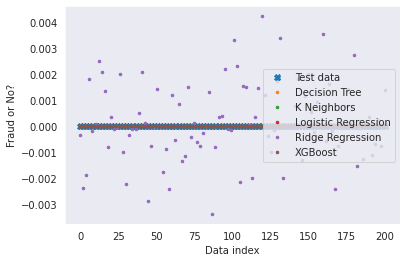

In [ ]:
#######  VISUALIZATION RESULTS ####

import matplotlib.pyplot as plt
import random

preds=pd.DataFrame()
preds['validation']=val_y
preds['tree']=y_pred_tree
preds['neighbors']=y_pred_nei
#preds['forest']=y_pred_for
preds['logistic']=y_pred_log
preds['ridge']=y_pred_rr
preds['xgboost']=y_pred_xgb

preds.describe()
pr=preds.sample(n=100)
ind = np.linspace(0,200,100)# len(val_y),len(val_y))
plt.xlabel('Data index')
plt.ylabel('Fraud or No?') 

plt.plot(ind, pr['validation'],'X', markersize=6,label='Test data' )
plt.plot(ind,pr['tree'], '.', markersize=5,label='Decision Tree')
plt.plot(ind,pr['neighbors'], '.', markersize=5,label='K Neighbors')
#plt.plot(ind,pr['forest'], '.', markersize=5,label='Random Forest')
plt.plot(ind,pr['logistic'], '.', markersize=5,label='Logistic Regression')
plt.plot(ind,pr['ridge'], '.', markersize=5,label='Ridge Regression')
plt.plot(ind,pr['xgboost'], '.', markersize=5,label='XGBoost')
plt.legend(loc='right')

plt.show()